# CAPEX Budget for the Sugarcane Mill Model

This notebook calculates the additional revenue generated by the sugarcane mill by including bio-jet fuel production as a function of bio-jet fuel premium price and compares this additional revenue to CAPEX costs for the conventional and optimistic ATJ technologies.

In [1]:
#stochastic_model_v2.py contains a function that builds the pyomo model of the sugarcane mill
from stochastic_model_v2 import *
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path  

In [2]:
#Load historical price data
df_hp = pd.read_excel('Mutran_jet_datav2.xlsx', sheet_name= 'Inflation')

#Convert data frame to indexed dictionary and add the premium to SAF
jet_price = df_hp['p_je']
eth_price = df_hp['p_et']
sugar_price = df_hp['p_su']


jet_price = jet_price.to_dict()
eth_price = eth_price.to_dict()
sugar_price = sugar_price.to_dict()

market_prices = {}
market_prices['s'] = sugar_price
market_prices['e'] = eth_price
market_prices['a'] = jet_price

scenarios = list(sugar_price.keys())

In [3]:
#Analyze the No Bio-jet fuel conventional case
premium = 0
cost = 637
conv = 0.409

m = create_stochastic_model_v2(premium, market_prices, scenarios, .2, .4, 0, .4, 1, 1, .42, 3200, 2600)

m.jet_conv = conv
m.jet_pc = cost

#Fix Bio-jet fuel production to 0
for i in m.SCENARIOS:
    m.x['a',i].fix(0)

sol =pyo.SolverFactory('gurobi', tee=True)
sol.solve(m)



{'Problem': [{'Name': 'x1', 'Lower bound': 334284675.45103896, 'Upper bound': 334284675.4510429, 'Number of objectives': 1, 'Number of constraints': 24288, 'Number of variables': 17428, 'Number of binary variables': 4752, 'Number of integer variables': 4752, 'Number of continuous variables': 12676, 'Number of nonzeros': 58080, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.15899991989135742', 'Error rc': 0, 'Time': 0.3795592784881592}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [4]:
reference_profit = pyo.value(m.obj)
print('Reference Case Profit: ', np.round(reference_profit,2), 'R$')

Reference Case Profit:  334284675.45 R$


In [5]:
#Set the Premium Range to Quantify the Profit Including Bio-jet Fuel
prem_range_USD = np.linspace(0,2,41)
prem_range_R = prem_range_USD*5.17*1000

#Create the First Instance of the Model with a Premium Price of 0, 
#and no flexibility to ensure a single flow for the entire year
m = create_stochastic_model_v2(0, market_prices, scenarios, .2, .4, 0.4, .4, 0, 0, .42, 3200, 2600)

#Set the Cost and Conversion Parameters
#Conventional
m.jet_conv = conv
m.jet_pc = cost

#Loop through the premium values and save the revenue and ethanol-to-jet fuel flow rate (e2)
profit_conv = []
ethanol_to_saf_conv = []
for i in range(len(prem_range_R)):
    m.premium = prem_range_R[i]
    sol =pyo.SolverFactory('gurobi', tee=True)
    sol.solve(m)
    profit_conv.append(pyo.value(m.obj))
    ethanol_to_saf_conv.append(pyo.value(m.y['e2']))

#Normalize the Additional Revenue to ethanol-to-jet (e2) flow rate
additional_conventional = (np.array(profit_conv)-reference_profit)/1e9
additional_conventional_scaled = (np.array(profit_conv)-reference_profit)/np.array(ethanol_to_saf_conv)
    
#Set the Cost and Conversion Parameters for the Optimistic Case
#Optimistic
m.jet_conv = 0.61
m.jet_pc = 461

profit_opt = []
ethanol_to_saf_opt = []
for i in range(len(prem_range_R)):
    m.premium = prem_range_R[i]
    sol =pyo.SolverFactory('gurobi', tee=True)
    sol.solve(m)
    profit_opt.append(pyo.value(m.obj))
    ethanol_to_saf_opt.append(pyo.value(m.y['e2']))
    
#Normalize the Additional Revenue to ethanol-to-jet (e2) flow rate
additional_optimistic = (np.array(profit_opt)-reference_profit)/1e9
additional_optimistic_scaled = (np.array(profit_opt)-reference_profit)/np.array(ethanol_to_saf_opt)

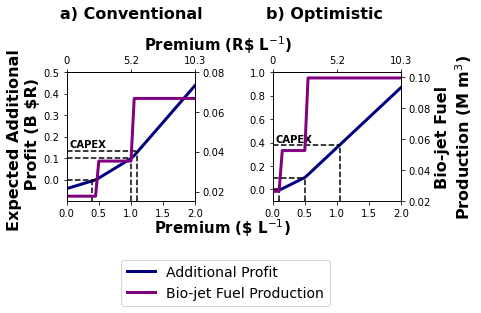

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.plot(prem_range_USD, additional_conventional, color = 'navy', linewidth = 3)
ax1.set_xticks([-0.1,0,0.5,1,1.5,2],fontsize = 12)
# ax1.hlines(2000,0,2,color='black', linestyle='--')
ax1.set_yticks([0,.10,.2,.3,.4,0.5], fontsize=12)
secax = ax1.secondary_xaxis(1)
secax.set_xticks([0, 1, 2], labels = [0,5.2,10.3], fontsize=10)
# ax1.set_xlabel('Premium (\$ L$^{-1}$)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Expected Additional \n Profit (B \$R)', fontsize = 16, fontweight='bold')
ax1.text(1.2,0.6,'Premium (R\$ L$^{-1}$)', fontsize=15, fontweight='bold')
ax1.text(1.35,-0.25,'Premium (\$ L$^{-1}$)', fontsize=15, fontweight='bold')
ax1.text(-0.1,0.75,'a) Conventional', fontsize=16, fontweight='bold')
ax1.text(3.1,0.75,'b) Optimistic', fontsize=16, fontweight='bold')
ax1.set_xlim(left=0,right=2)
ax1.set_ylim(bottom=-0.1)

ax3 = ax1.twinx()
ax3.set_box_aspect(1)

ax3.plot(prem_range_USD, np.array(ethanol_to_saf_conv)*0.409/1e6,color='purple', linewidth = 3)

ax2.plot(prem_range_USD, additional_optimistic, color='navy', label = 'Additional Profit', linewidth = 3)
ax2.set_xticks([0,0.5,1,1.5,2],fontsize = 12)
ax2.set_yticks([0,.2,.4,.6,.8,1], fontsize=12)
secax = ax2.secondary_xaxis(1)
secax.set_xticks([0, 1, 2], labels = [0,5.2,10.3], fontsize=10)
ax2.set_xlim(left=0,right=2)
ax2.set_ylim(bottom=-0.1)
# ax1.text(0.05,1700,'CAPEX \n(conventional)', color='black', fontweight='bold', fontsize = 12)
# ax2.text(1.3,2350,'CAPEX', color='black', fontweight='bold', fontsize = 12)
# ax2.text(0.9,1600,'(optimistic)', color='black', fontweight='bold',fontsize=12)
ax2.hlines(0,0,.1,color='black', linestyle='--')
ax2.hlines(0.1,0,0.5, color='black',linestyle='--')
ax2.hlines(0.38,0,1.05, color='black',linestyle='--')

ax2.vlines(.1,-0.1,0,color='black',linestyle='--')
ax2.vlines(.5,-0.1,0.1,color='black',linestyle='--')
ax2.vlines(1.05,-0.1,0.38,color='black',linestyle='--')

ax1.hlines(0,0,.5,color='black', linestyle='--')
ax1.hlines(0.1,0,1, color='black',linestyle='--')
ax1.hlines(0.135,0,1.1, color='black',linestyle='--')

ax1.vlines(.4,-0.1,0,color='black',linestyle='--')
ax1.vlines(1,-0.1,.1,color='black',linestyle='--')
ax1.vlines(1.1,-0.1,0.135,color='black',linestyle='--')

ax1.text(0.05,.15,'CAPEX',fontweight='bold',fontsize=10)
ax2.text(0.05,.4,'CAPEX',fontweight='bold',fontsize = 10)

# ax1.legend(loc = 'lower right', fontsize = 10)

ax4 = ax2.twinx()
ax4.set_box_aspect(1)

ax4.plot(prem_range_USD, np.array(ethanol_to_saf_opt)*0.61/1e6,color='purple', label = 'Bio-jet Fuel Production', linewidth = 3)
ax4.set_ylabel('Bio-jet Fuel\nProduction (M m$^3$)',fontsize = 16, fontweight='bold')
ax4.set_yticks([0.02,.04,.06,.08,.1], fontsize=12)

ax3.set_yticks([0.02,.04,.06,.08], fontsize=12)

fig.legend(bbox_to_anchor=(0.75, 0.1),fontsize=14)

plt.subplots_adjust(wspace = 0.6)

plt.savefig('capex_budget_unscaled_total.png',bbox_inches='tight',dpi=400)
plt.show()

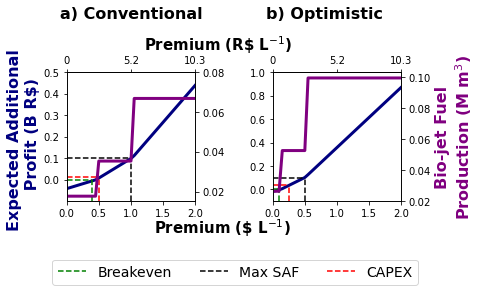

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

ax1.plot(prem_range_USD, additional_conventional, color = 'navy', linewidth = 3)
ax1.set_xticks([-0.1,0,0.5,1,1.5,2],fontsize = 12)
# ax1.hlines(2000,0,2,color='black', linestyle='--')
ax1.set_yticks([0,.10,.2,.3,.4,0.5], fontsize=12)
secax = ax1.secondary_xaxis(1)
secax.set_xticks([0, 1, 2], labels = [0,5.2,10.3], fontsize=10)
# ax1.set_xlabel('Premium (\$ L$^{-1}$)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Expected Additional \n Profit (B R\$)', fontsize = 16, fontweight='bold', color = 'navy')
ax1.text(1.2,0.6,'Premium (R\$ L$^{-1}$)', fontsize=15, fontweight='bold')
ax1.text(1.35,-0.25,'Premium (\$ L$^{-1}$)', fontsize=15, fontweight='bold')
ax1.text(-0.1,0.75,'a) Conventional', fontsize=16, fontweight='bold')
ax1.text(3.1,0.75,'b) Optimistic', fontsize=16, fontweight='bold')
ax1.set_xlim(left=0,right=2)
ax1.set_ylim(bottom=-0.1)

ax3 = ax1.twinx()
ax3.set_box_aspect(1)

ax3.plot(prem_range_USD, np.array(ethanol_to_saf_conv)*0.409/1e6,color='purple', linewidth = 3)

ax2.plot(prem_range_USD, additional_optimistic, color='navy', linewidth = 3)
ax2.set_xticks([0,0.5,1,1.5,2],fontsize = 12)
ax2.set_yticks([0,.2,.4,.6,.8,1], fontsize=12)
secax = ax2.secondary_xaxis(1)
secax.set_xticks([0, 1, 2], labels = [0,5.2,10.3], fontsize=10)
ax2.set_xlim(left=0,right=2)
ax2.set_ylim(bottom=-0.1)
# ax1.text(0.05,1700,'CAPEX \n(conventional)', color='black', fontweight='bold', fontsize = 12)
# ax2.text(1.3,2350,'CAPEX', color='black', fontweight='bold', fontsize = 12)
# ax2.text(0.9,1600,'(optimistic)', color='black', fontweight='bold',fontsize=12)
ax2.hlines(0,0,.1,color='green', linestyle='--')
ax2.hlines(0.1,0,0.5, color='black',linestyle='--')
ax2.hlines(0.04,0,.25, color='red',linestyle='--')

ax2.vlines(.1,-0.1,0,color='green',linestyle='--', label='Breakeven')
ax2.vlines(.5,-0.1,0.1,color='black',linestyle='--',label='Max SAF')
ax2.vlines(.25,-0.1,0.04,color='red',linestyle='--',label='CAPEX')

ax1.hlines(0,0,.4,color='green', linestyle='--')
ax1.hlines(0.1,0,1, color='black',linestyle='--')
ax1.hlines(0.013,0,0.5, color='red',linestyle='--')

ax1.vlines(.4,-0.1,0,color='green',linestyle='--')
ax1.vlines(1,-0.1,.1,color='black',linestyle='--')
ax1.vlines(.5,-0.1,0.013,color='red',linestyle='--')


# ax1.legend(loc = 'lower right', fontsize = 10)

ax4 = ax2.twinx()
ax4.set_box_aspect(1)

ax4.plot(prem_range_USD, np.array(ethanol_to_saf_opt)*0.61/1e6,color='purple', linewidth = 3)
ax4.set_ylabel('Bio-jet Fuel\nProduction (M m$^3$)',fontsize = 16, fontweight='bold', color='purple')
ax4.set_yticks([0.02,.04,.06,.08,.1], fontsize=12)

ax3.set_yticks([0.02,.04,.06,.08], fontsize=12)

fig.legend(bbox_to_anchor=(0.955, .1),fontsize=14,ncol=3)

plt.subplots_adjust(wspace = 0.6)

plt.savefig('capex_budget_unscaled_annual.png',bbox_inches='tight',dpi=400)
plt.show()

In [20]:
#Annualization Factor
r = 0.08 #discount rate
n = 20 #Equipment life

af = ((1+r)**n - 1)/(r*(1+r)**n)

print('Annualization Factor:', np.round(1/af,3))

Annualization Factor: 0.102
